# Adaptive Cruise Control

In [1]:
import matplotlib.pyplot as plt
import hj_reachability as hj
import jax.numpy as jnp
import numpy as np
import seaborn as sns
import os
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as anim

In [2]:
sys.path.insert(1, '../../lib')
import refine_cbfs
import experiment_wrapper
import cbf_opt
from experiment_wrapper import RolloutTrajectory, TimeSeriesExperiment, StateSpaceExperiment
from cbf_opt import ControlAffineDynamics, ControlAffineCBF, ControlAffineASIF

## Setup Problem (dynamics, environment and CBF)

Dynamics of the Adaptive Cruise Control problem (control affine), in the format of `cbf_opt`

`ACC_JNP_Dynamics` is required for usage with `hj_reachability` module

In [3]:
class ACCDynamics(ControlAffineDynamics):
    STATES = ['P', 'V', 'dP'] # position, velocity, distance between cars
    CONTROLS = ['ACC']
    def __init__(self, params, **kwargs):
        params['n_dims'] = 3
        params['control_dims'] = 1  # TODO: How to do this correctly?
        self.mass = params["mass"]
        self.g = params["g"]
        self.f0 = params["f0"]
        self.f1 = params["f1"]
        self.f2 = params["f2"]
        self.rolling_resistance = lambda x: self.f0 + self.f1 * x[..., 1] + self.f2 * x[..., 1] ** 2
        self.v0 = params["v0"]
        super().__init__(params, **kwargs)

    def state_jacobian(self, state, control, time=0.):
        J = np.repeat(np.zeros_like(state)[..., None], self.n_dims, axis=-1)
        J[..., 0, 1] = 1
        J[..., 1, 1] = -1 / self.mass * (self.f1 + 2 * self.f2 * state[..., 1])
        J[..., 2, 1] = -1 
        return J
        
    def open_loop_dynamics(self, state, time=0.):
        f = np.zeros_like(state)
        f[..., 0] = state[..., 1]
        f[..., 1] = -1 / self.mass * self.rolling_resistance(state)
        f[..., 2] = self.v0 - state[..., 1]
        return f

    def control_matrix(self, state, time=0.):
        B = np.repeat(np.zeros_like(state)[..., None], self.control_dims, axis=-1)
        B[..., 1, 0] = 1 / self.mass 
        return B


class ACCJNPDynamics(ACCDynamics):
    def __init__(self, params, **kwargs):
        super().__init__(params, **kwargs)
        self.rolling_resistance = lambda x: self.f0 + self.f1 * x[1] + self.f2 * x[1] ** 2

    def open_loop_dynamics(self, state, time=0.0):
        return jnp.array([state[1], -1 / self.mass * self.rolling_resistance(state), self.v0 - state[1]])

    def control_matrix(self, state, time=0.0):
        return jnp.expand_dims(jnp.array([0, 1 / self.mass, 0]), axis=-1)

    def disturbance_jacobian(self, state, time=0.0):
        return jnp.expand_dims(jnp.zeros(3), axis=-1)

Setting up the Dynamics with specific parameters for dry road and ice road

In [4]:
# common parameters
params_common = dict()
params_common["dt"] = 0.01
params_common["g"] = 9.81
params_common['v0'] = 14  # lead vehicle velocity
params_common['mass'] = 1650  # vehicle mass

In [5]:
# dry road
params_dry = params_common.copy()
params_dry['f0'] = 0.1 * 3  # friction coefficient
params_dry['f1'] = 5 * 3  # friction coefficient
params_dry['f2'] = 0.25 * 3  # friction coefficient
acc_dry = ACCDynamics(params_dry)
acc_jnp_dry = ACCJNPDynamics(params_dry)

# ice road
params_ice = params_common.copy()
params_ice['f0'] = 0.1
params_ice['f1'] = 5
params_ice['f2'] = 0.25
acc_ice = ACCDynamics(params_ice)
acc_jnp_ice = ACCJNPDynamics(params_ice)

# Constructing Initial Local CBFs

In [6]:
class ACCCBF(ControlAffineCBF):
    def __init__(self, dynamics, params, cd_limit, **kwargs):
        self.Th = params["Th"]
        self.cd = cd_limit
        super().__init__(dynamics, params, **kwargs)

    def vf(self, state, time=None):
        return state[..., 2] - self.Th * state[..., 1] - (state[..., 1] - self.dynamics.v0) ** 2 / (2 * self.cd * self.dynamics.g)

    def vf_dt_partial(self, state, time=None):
        return 0.0
    
    def _grad_vf(self, state, time=None):
        dvf_dx = np.zeros_like(state)
        dvf_dx[..., 1] = - self.Th  - (state[..., 1] - self.dynamics.v0) / (self.cd * self.dynamics.g)
        dvf_dx[..., 2] = 1.0
        return dvf_dx

Setting up the CBF with specific parameter instantiation

In [7]:
cbf_params = dict()
cbf_params["Th"] = 1.8
control_limit_dry = 0.3
control_limit_ice = 0.1

acc_cbf_dry = ACCCBF(acc_dry, cbf_params, control_limit_dry)
acc_jnp_cbf_dry = ACCCBF(acc_jnp_dry, cbf_params, control_limit_dry)

umax_dry = np.array([control_limit_dry * params_dry['mass'] * params_dry['g']])
umin_dry = - umax_dry

acc_cbf_ice = ACCCBF(acc_ice, cbf_params, control_limit_ice)
acc_jnp_cbf_ice = ACCCBF(acc_jnp_ice, cbf_params, control_limit_ice)

umax_ice = np.array([control_limit_ice * params_ice['mass'] * params_ice['g']])
umin_ice = - umax_ice

### Environment

In [8]:
dyn_reachability_jnp_dry = refine_cbfs.HJControlAffineDynamics(acc_jnp_dry, control_space=hj.sets.Box(jnp.array(umin_dry), jnp.array(umax_dry)))
dyn_reachability_dry = refine_cbfs.HJControlAffineDynamics(acc_dry, control_space=hj.sets.Box(jnp.array(umin_dry), jnp.array(umax_dry)))

dyn_reachability_jnp_ice = refine_cbfs.HJControlAffineDynamics(acc_jnp_ice, control_space=hj.sets.Box(jnp.array(umin_ice), jnp.array(umax_ice)))
dyn_reachability_ice = refine_cbfs.HJControlAffineDynamics(acc_ice, control_space=hj.sets.Box(jnp.array(umin_ice), jnp.array(umax_ice)))

low_bound = jnp.array([0., 10., 0.])
high_bound = jnp.array([500, 40., 100.])
nbr_pts = (101, 101, 101)
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(low_bound, high_bound), nbr_pts)
grid_np = refine_cbfs.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(low_bound, high_bound), nbr_pts)

In [9]:
obstacle_dry = grid.states[..., 2] - acc_cbf_dry.Th * grid.states[..., 1]
obstacle_ice = grid.states[..., 2] - acc_cbf_ice.Th * grid.states[..., 1]
assert obstacle_dry.all() == obstacle_ice.all()

## Obtain the initial local CBFs using Dynamic Programming

In [10]:
acc_tabular_cbf_dry = refine_cbfs.TabularControlAffineCBF(acc_dry, dict(), grid=grid)
acc_jnp_tabular_cbf_dry = refine_cbfs.TabularControlAffineCBF(acc_jnp_dry, dict(), grid=grid)
acc_tabular_cbf_dry.tabularize_cbf(acc_cbf_dry)
acc_jnp_tabular_cbf_dry.tabularize_cbf(acc_jnp_cbf_dry)

acc_tabular_cbf_ice = refine_cbfs.TabularControlAffineCBF(acc_ice, dict(), grid=grid)
acc_jnp_tabular_cbf_ice = refine_cbfs.TabularControlAffineCBF(acc_jnp_ice, dict(), grid=grid)
acc_tabular_cbf_ice.tabularize_cbf(acc_cbf_ice)
acc_jnp_tabular_cbf_ice.tabularize_cbf(acc_jnp_cbf_ice)

In [11]:
# backward reachability setups
time = 0.
target_time = - 20.0
times = jnp.linspace(time, target_time, 101)
backwards_reachable_tube = lambda obstacle: (lambda t, x: jnp.minimum(x, obstacle))

In [12]:
# compute ice CBF values, it takes around 2 mins on desktop

solver_settings = hj.SolverSettings.with_accuracy("medium",
                                                  value_postprocessor=backwards_reachable_tube(obstacle_ice))
init_value = acc_jnp_tabular_cbf_ice.vf_table

# unsafe set: the last value is negative
target_values_hjr_ice = hj.solve(solver_settings, dyn_reachability_jnp_ice, grid, times, obstacle_ice)
target_values_ice = hj.solve(solver_settings, dyn_reachability_jnp_ice, grid, times, init_value)

100%|##########| 20.0000/20.0 [01:20<00:00,  4.05s/sim_s]
100%|##########| 20.0000/20.0 [01:20<00:00,  4.01s/sim_s]


In [13]:
# compute dry CBF values, it takes around 2 mins on desktop

solver_settings = hj.SolverSettings.with_accuracy("medium",
                                                  value_postprocessor=backwards_reachable_tube(obstacle_dry))
init_value_dry = acc_jnp_tabular_cbf_dry.vf_table
target_values_hjr_dry= hj.solve(solver_settings, dyn_reachability_jnp_dry, grid, times, obstacle_dry)
target_values_dry = hj.solve(solver_settings, dyn_reachability_jnp_dry, grid, times, init_value_dry)

100%|##########| 20.0000/20.0 [01:34<00:00,  4.74s/sim_s]
100%|##########| 20.0000/20.0 [01:34<00:00,  4.75s/sim_s]


In [14]:
dataset_path = "../../dataset/acc_data"
if not os.path.isdir(dataset_path):
    os.makedirs(dataset_path)

In [15]:
# save data

with open(dataset_path + "/target_values_ice.npy", "wb") as f:
    jnp.save(f, target_values_ice)
with open(dataset_path + "/target_values_hjr_ice.npy", "wb") as f:
    jnp.save(f, target_values_hjr_ice)
with open(dataset_path + "/target_values_dry.npy", "wb") as f:
    jnp.save(f, target_values_dry)
with open(dataset_path + "/target_values_hjr_dry.npy", "wb") as f:
    jnp.save(f, target_values_hjr_dry)

In [16]:
# if you have computed values before, then just read them

target_values_ice = jnp.load(dataset_path + "/target_values_ice.npy")
target_values_hjr_ice = jnp.load(dataset_path + "/target_values_hjr_ice.npy")
target_values_dry = jnp.load(dataset_path + "/target_values_dry.npy")
target_values_hjr_dry = jnp.load(dataset_path + "/target_values_hjr_dry.npy")

In [17]:
assert jnp.sum(jnp.where(target_values_ice[-1] > 0, 1, 0) ) == jnp.sum(jnp.where(target_values_dry[-1] > 0, 1, 0) * jnp.where(target_values_ice[-1] > 0, 1, 0))

In [18]:
switch_position = 100
switch_radius = 1.
switch = abs(grid.states[..., 0] - switch_position) - switch_radius # considered as switching area

# the intersection of safe dry and unsafe ice regions
unsafe_ice_values = target_values_dry * target_values_ice

# safe switching area
safe_switch = jnp.maximum(switch, unsafe_ice_values[-1])

We need to refine dry CBF to make it aware of switching.
Now, turning the converged dry value function into a CBVF that interfaces with `cbf_opt`

In [19]:
# initialization with original local dry CBF

refined_dry_cbf = refine_cbfs.TabularControlAffineCBF(acc_dry, grid=grid_np)
refined_dry_cbf_jnp = refine_cbfs.TabularControlAffineCBF(acc_jnp_dry, grid=grid)
refined_dry_cbf.vf_table = np.array(target_values_dry[-1])
refined_dry_cbf_jnp.vf_table = target_values_dry[-1]

In [20]:
# compute refined dry CBF values, it takes around 1 min on desktop

new_obstacle = jnp.minimum(safe_switch, target_values_dry[-1])
solver_settings = hj.SolverSettings.with_accuracy("medium",
                                                  value_postprocessor=backwards_reachable_tube(new_obstacle))
init_value_refine_dry = refined_dry_cbf.vf_table
target_values_refine_dry = hj.solve(solver_settings, dyn_reachability_jnp_dry, grid, times, init_value_refine_dry)

100%|##########| 20.0000/20.0 [01:34<00:00,  4.75s/sim_s]


In [21]:
# save data
with open(dataset_path + "/target_values_refined_dry.npy", "wb") as f:
    jnp.save(f, target_values_refine_dry)

In [22]:
# read data
target_values_refine_dry = jnp.load(dataset_path + "/target_values_refined_dry.npy")

In [23]:
refined_cbf_dry = refine_cbfs.TabularControlAffineCBF(acc_dry, grid=grid_np)
refined_cbf_dry.vf_table = np.array(target_values_refine_dry[-1])

## Running an experiment

In [24]:
x0 = np.array([0, 30, 90])
n_sims_per_start = 1
t_sim = 20

Setting up the nominal controller
We simply tune a proporitional controller for the nominal controller

In [25]:
desired_vel = 35
feedback_gain = 200
nominal_policy = lambda x, t: np.atleast_1d(np.clip(-feedback_gain * (x[..., 1] - desired_vel), umin_dry, umax_dry))
nominal_policy_jnp = lambda x, t: jnp.atleast_1d(jnp.clip(-feedback_gain * (x[..., 1] - desired_vel), umin_dry, umax_dry))

### Setting up the safety filter

In [26]:
alpha_dry = lambda x: 0.2 * x
alpha_ice = lambda x: 5. * x

acc_asif_dry = ControlAffineASIF(acc_dry, acc_cbf_dry, alpha=alpha_dry, nominal_policy=nominal_policy, umin=umin_dry, umax=umax_dry)
acc_asif_ice = ControlAffineASIF(acc_ice, acc_cbf_ice, alpha=alpha_ice, nominal_policy=nominal_policy, umin=umin_ice, umax=umax_ice)
acc_asif_global = ControlAffineASIF(acc_ice, acc_cbf_ice, alpha=alpha_ice, nominal_policy=nominal_policy, umin=umin_dry, umax=umax_dry)
acc_asif_dry_optimal = ControlAffineASIF(acc_dry, refined_cbf_dry, alpha=alpha_dry, nominal_policy=nominal_policy, umin=umin_dry, umax=umax_dry)
acc_asif_dry_refined = ControlAffineASIF(acc_dry, refined_cbf_dry, alpha=alpha_dry, nominal_policy=nominal_policy, umin=umin_dry, umax=umax_dry)

Visualizations for paper + demo + videos

Safe set visualization

In [27]:
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size': '28',
    'text.usetex': False,
    'pgf.rcfonts': False,
})

colors = sns.color_palette("tab10")
chosen_colors = [(0.5, 0.5, 0.5)]
chosen_colors.append(colors[0])
chosen_colors.append(colors[1])

colors = [(0.3, 0.3, 0.3)]
colors += [(sns.color_palette("RdYlGn_r", 7)[0])]
colors += [(sns.color_palette("RdYlGn_r", 9)[6])]
colors += [(sns.color_palette("RdYlGn_r", 9)[8])]
colors += [(4 / 255, 101 / 255, 4 / 255)]
colors = np.array(colors)

alt_colors = sns.color_palette("pastel", 9).as_hex()

### Online: Safety filter visualization

In [28]:
experiment_paper = RolloutTrajectory('acc_example', start_x=x0, n_sims_per_start=n_sims_per_start, t_sim=t_sim)

In [29]:
index_method_dict = {
        0: "vanilla",
        1: "ours",
        2: "global"
    }

In [36]:
for method_index in range(3):

    if method_index == 0:
        phase1_controller = acc_asif_dry
    elif method_index == 2:
        phase1_controller = acc_asif_global
    else:
        phase1_controller = acc_asif_dry_refined

    paper_results, jump_state, traj = experiment_paper.run_hybrid(acc_dry, acc_ice, {'nominal': nominal_policy, 'Analytical': phase1_controller}, {'nominal': nominal_policy, 'Analytical': acc_asif_ice}, switch_position)

    if method_index == 0:
        traj_vanilla = traj
    elif method_index == 2:
        traj_global = traj
    else:
        traj_ours = traj
        
    assert abs(jump_state[0, 0] - switch_position) <= switch_radius

x_current (position, velocity, distance):  [[ 0. 30. 90.]] (1, 3)


Controller rollout: 100%|██████████| 2000/2000 [00:00<00:00, 22238.50it/s]


switching time:  3.34
x_current (position, velocity, distance):  [[ 0. 30. 90.]] (1, 3)


Controller rollout:  23%|██▎       | 455/2000 [00:00<00:02, 569.35it/s]

switching time:  3.81


Controller rollout: 100%|██████████| 2000/2000 [00:03<00:00, 592.33it/s]


x_current (position, velocity, distance):  [[ 0. 30. 90.]] (1, 3)


Controller rollout: 100%|██████████| 2000/2000 [00:00<00:00, 25010.38it/s]


switching time:  3.34
x_current (position, velocity, distance):  [[ 0. 30. 90.]] (1, 3)


Controller rollout:  24%|██▍       | 482/2000 [00:01<00:03, 490.02it/s]

switching time:  3.97


Controller rollout: 100%|██████████| 2000/2000 [00:03<00:00, 518.77it/s]


x_current (position, velocity, distance):  [[ 0. 30. 90.]] (1, 3)


Controller rollout: 100%|██████████| 2000/2000 [00:00<00:00, 20502.32it/s]


switching time:  3.34
x_current (position, velocity, distance):  [[ 0. 30. 90.]] (1, 3)


Controller rollout:  26%|██▋       | 525/2000 [00:00<00:02, 568.00it/s]

switching time:  4.21


Controller rollout: 100%|██████████| 2000/2000 [00:03<00:00, 569.12it/s]


In [37]:
# save trajectories data
with open(dataset_path + "/traj_vanilla.npy", "wb") as f:
   jnp.save(f, traj_vanilla)
with open(dataset_path + "/traj_ours.npy", "wb") as f:
   jnp.save(f, traj_ours)
with open(dataset_path + "/traj_global.npy", "wb") as f:
   jnp.save(f, traj_global)

In [51]:
results_path = '../../results/acc_results'

In [52]:
with open(results_path + "/traj_vanilla.npy", "rb") as f:
    traj_vanilla = jnp.load(f)
with open(results_path + "/traj_ours.npy", "rb") as f:
    traj_ours = jnp.load(f)
with open(results_path + "/traj_global.npy", "rb") as f:
    traj_global = jnp.load(f)
with open(results_path + "/traj_mpc.npy", "rb") as f:
    traj_mpc = jnp.load(f)
with open(results_path + "/traj_ours_previous.npy", "rb") as f:
    traj_ours_acc = jnp.load(f)

In [53]:
method_index = 4 # 0 is vanilla, 1 is ours, 2 is ACC paper approach, 3 is global CBF, 4 is MPC

if method_index == 0:
    traj = traj_vanilla
elif method_index == 1:
    traj = traj_ours
elif method_index == 2:
    traj = traj_ours_acc
elif method_index == 3:
    traj = traj_global
else:
    with open(results_path + "/traj_mpc.npy", "rb") as f:
        traj_mpc = jnp.load(f)
    traj = traj_mpc
    
colors = sns.color_palette("tab10")
alt_colors = sns.color_palette("pastel", 9).as_hex()
toggle_hjr_visualization = False
save_video = False
results_path = "../../results"
video_file_name = results_path + "acc.gif"

/tmp/ipykernel_1139715/35124947.py:65: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for pc in cont.collections]
/tmp/ipykernel_1139715/35124947.py:67: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  proxy += [plt.Rectangle((0,0),1,1,ec =colors[-1], fc='white', lw=5) for pc in cont.collections]
/tmp/ipykernel_1139715/35124947.py:74: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for pc in cs.collections]
/tmp/ipykernel_1139715/35124947.py:77: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for pc in cs.collections]
/tmp/ipykernel_1139715/35124947.py:79: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplot

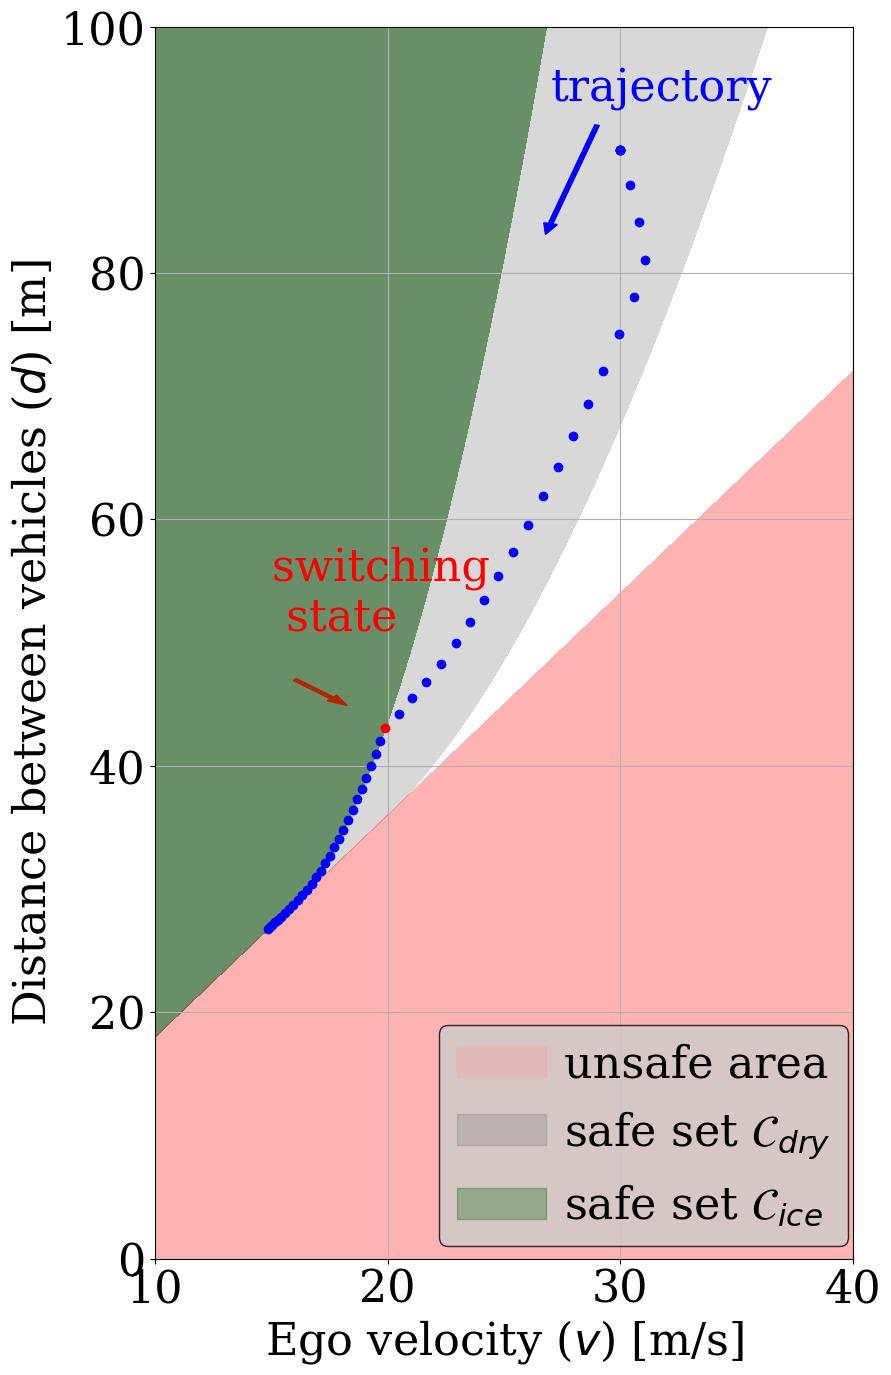

In [54]:
font_size = 32
params = {'axes.labelsize': font_size, 'axes.titlesize':font_size, 'font.size': font_size, 'legend.fontsize': font_size, 
          'xtick.labelsize': font_size, 'ytick.labelsize': font_size, 'lines.linewidth': 5}
matplotlib.rcParams.update(params)

def render_frame(i, colorbar=False):
    global cont
    # global cont_new
    for c in cont.collections:
        c.remove()
    # timestamp.set_text("Time step = {}".format(i))

    if traj[i*20][0] >= switch_position - 2. and traj[i*20][0] <= switch_position + 2.:
        switch_index = i
        newpoint, = ax.plot(traj[i*20][1], traj[i*20][2], color="red", marker="o")
        ## for our good traj
        if method_index == 1:
            ax.text(12, 50, 'switching \n state', fontsize = font_size, color = 'red')
            ax.arrow(17,48, 1.6,-1.5,width=0.2, color = 'red')
        # for bad traj
        elif method_index == 0:
            ax.text(14.5, 49.5, 'switching \n state', fontsize = font_size, color = 'red')
            ax.arrow(18.6, 47.5, 1.6,-1.5,width=0.2, color = 'red')
        # for ACC paper good traj
        elif method_index == 2:
            ax.text(13, 50, 'switching \n state', fontsize = font_size, color = 'red')
            ax.arrow(17,48, 1.6,-1.5,width=0.2, color = 'red')
        # for global CBF
        elif method_index == 3:
            ax.text(11, 53, 'switching \n state', fontsize = font_size, color = 'red')
            ax.arrow(16,52, 1.6,-1.5,width=0.2, color = 'red')
        # for mpc
        else:
            ax.text(15, 51, 'switching \n state', fontsize = font_size, color = 'red')
            ax.arrow(16, 47, 1.6, -1.5,width=0.2, color = 'red')

    else:
        newpoint, = ax.plot(traj[i*20][1], traj[i*20][2], color='blue', marker="o")
    
    if True: # traj[i*20][0] >= switch_position + 0.5:
        cont = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[2], target_values_ice[-1][i].T, levels=[0, 200], 
                 colors='green', alpha=0.3)
    # else:
    #     cont = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[2], target_values_refine_dry[-1][i].T, levels=[0, 200], 
    #              colors='green', alpha=0.3)

proxy = [] 

fig, ax = plt.subplots(figsize=(9, 16))

obstacle_viz = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[2], obstacle_dry[0].T, levels=[-100, 0], 
                 colors='red', alpha=0.3)


cs = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[2], target_values_dry[-1][0].T, levels=[0, 200], 
                 colors='grey', alpha=0.3)

cs = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[2], target_values_ice[-1][0].T, levels=[0, 200], 
                 colors='black', alpha=0.3)

cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[2], target_values_dry[0][0].T, levels=[0], 
                  colors=np.array([colors[3]]))   # Initial CBF

proxy += [plt.Rectangle((0,0),1,1,ec =colors[3], fc='white', lw=5)
        for pc in cont.collections]

proxy += [plt.Rectangle((0,0),1,1,ec =colors[-1], fc='white', lw=5) for pc in cont.collections]

timestamp = ax.text(0.05, 0.9, "", transform=ax.transAxes)

ax.grid()
proxy2 = []
proxy2 += [plt.Rectangle((0,0),1,1,fc = alt_colors[3], ec=alt_colors[3], alpha=0.3)
        for pc in cs.collections]

proxy2 += [plt.Rectangle((0,0),1,1,fc = 'grey', ec='grey', alpha=0.3)
        for pc in cs.collections]

proxy2 += [plt.Rectangle((0,0),1,1, fc='darkgreen', ec='darkgreen', alpha=0.3) for pc in obstacle_viz.collections]

# proxy2 += [plt.Rectangle((0,0),1,1, fc='green', ec='green', alpha=0.3) for pc in obstacle_viz.collections]

legend_entries = ["$\partial \mathcal{C}_h$", "$\partial \mathcal{C}_h(t)$"]
if toggle_hjr_visualization:
    legend_entries += ["$\partial \mathcal{C}_{\ell}(t)$"]

ax.arrow(29,92,-2,-8,width=0.2, color = 'blue')
ax.text(27, 94, 'trajectory', fontsize = font_size, color = 'blue')

ax.legend(proxy2, ["unsafe area", "safe set $\mathcal{C}_{dry}$", "safe set $\mathcal{C}_{ice}$"],
          loc='center', bbox_to_anchor=(0.70, 0.1), ncol=1, columnspacing=1.5, handletextpad=0.4,
          facecolor=[0.8, 0.8, 0.8], edgecolor='black')

ax.set_ylabel("Distance between vehicles ($d$) [m]")
ax.set_xlabel("Ego velocity ($v$) [m/s]")

render_frame(0, False)
animation = anim.FuncAnimation(fig, render_frame, 50, interval=200)
save_video = True
if save_video:
   animation.save(video_file_name, writer='ffmpeg')